In [31]:
# Imports
from typing import List
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import uuid
import copy

In [32]:
from tokens import *

In [33]:
# Token class
class Token:
    def __init__(self, t_type: str, t_value:str = None):
        self.t_type = t_type
        self.t_value = t_value

In [34]:
# Tree Node Class
class Node:
    def __init__(self, val:str, left=None, right=None, parent=None):
        self.val = val
        self.left = left
        self.right = right
        self.parent = parent
        self.ID = uuid.uuid4()
        
    def __eq__(self, other):
        return isinstance(other, Node) and self.ID == other.ID
        
    def __repr__(self):
        return f"[{self.val} | Left: {self.left} | Right: {self.right} | Parent: {self.parent.val if self.parent else None}]"
    
    # Does create new ID's - so not a complete deepcopy
    def __copy__(self, parent=None):
        root = Node(self.val, parent=parent)
        root.left = copy.copy(self.left) if self.left else None
        root.right = copy.copy(self.right) if self.right else None
        
        if root.right:
            root.right.parent = root
        if root.left:
            root.left.parent = root
        
        return root

In [35]:
n1 = Node(2)
n2 = Node(2)
n1 == n2, None == n1, n1 == n1

(False, False, True)

# Helper Functions
An important thing to have in mind when reading these helper functions is that we don't care about the mathematical correctness of the prediction graph or any modifications of it as we already have correctness of the final graph that we want to find

In [36]:
# Distance should be 5
# 1) Replace root values
# 2) Delete log and replace with child
# 3) Swap the two children of '-'
# 4) Replace '-' --> '*'
# 5) Replace '*' --> '-'
correct_test = [Token(TT_INTEGER), Token(TT_INTEGER), Token(TT_PI), Token(TT_MULTIPLY), Token(TT_MINUS), Token(TT_INTEGER), Token(TT_DIVIDE)] # (Z - Z*PI)/Z
predict_test = [Token(TT_INTEGER), Token(TT_PI), Token(TT_MINUS), Token(TT_INTEGER), Token(TT_MULTIPLY), Token(TT_INTEGER), Token(TT_LOG), Token(TT_MINUS)] # (Z - PI)*Z - log(Z)

In [37]:
# Input is token list - defaults to right side - returns the last position at which 
def graph_from_postfix(postfix:List[Token], parent=None) -> tuple:
    pointer = len(postfix)-1
    token = postfix[pointer].t_type
    root = Node(token)
    root.parent = parent
    if token in unary_operators:
        pointer, root.right = graph_from_postfix(postfix[:pointer], root)
    elif token in binary_operators:
        pointer, root.right = graph_from_postfix(postfix[:pointer], root)
        pointer, root.left = graph_from_postfix(postfix[:pointer], root)
    
    return pointer, root
_, predict_graph = graph_from_postfix(predict_test)
_, correct_graph = graph_from_postfix(correct_test)
correct_graph

[TT_DIVIDE | Left: [TT_MINUS | Left: [TT_INTEGER | Left: None | Right: None | Parent: TT_MINUS] | Right: [TT_MULTIPLY | Left: [TT_INTEGER | Left: None | Right: None | Parent: TT_MULTIPLY] | Right: [TT_PI | Left: None | Right: None | Parent: TT_MULTIPLY] | Parent: TT_MINUS] | Parent: TT_DIVIDE] | Right: [TT_INTEGER | Left: None | Right: None | Parent: TT_DIVIDE] | Parent: None]

In [38]:
copy.copy(correct_graph)

[TT_DIVIDE | Left: [TT_MINUS | Left: [TT_INTEGER | Left: None | Right: None | Parent: TT_MINUS] | Right: [TT_MULTIPLY | Left: [TT_INTEGER | Left: None | Right: None | Parent: TT_MULTIPLY] | Right: [TT_PI | Left: None | Right: None | Parent: TT_MULTIPLY] | Parent: TT_MINUS] | Parent: TT_DIVIDE] | Right: [TT_INTEGER | Left: None | Right: None | Parent: TT_DIVIDE] | Parent: None]

In [39]:
# This is to get a fingerprint of each graph
def graph_to_postfix(root:Node):
    if not root: return []
    postfix = graph_to_postfix(root.left)
    postfix += graph_to_postfix(root.right)
    postfix += [root.val]
    return postfix
graph_to_postfix(correct_graph) # Note that the '\\' are just a consequence of the symbols being stored in latex format

['TT_INTEGER',
 'TT_INTEGER',
 'TT_PI',
 'TT_MULTIPLY',
 'TT_MINUS',
 'TT_INTEGER',
 'TT_DIVIDE']

In [40]:
def node_count(root):
    if not root:
        return 0
    
    return node_count(root.left) + node_count(root.right) + 1
node_count(correct_graph) # 7

7

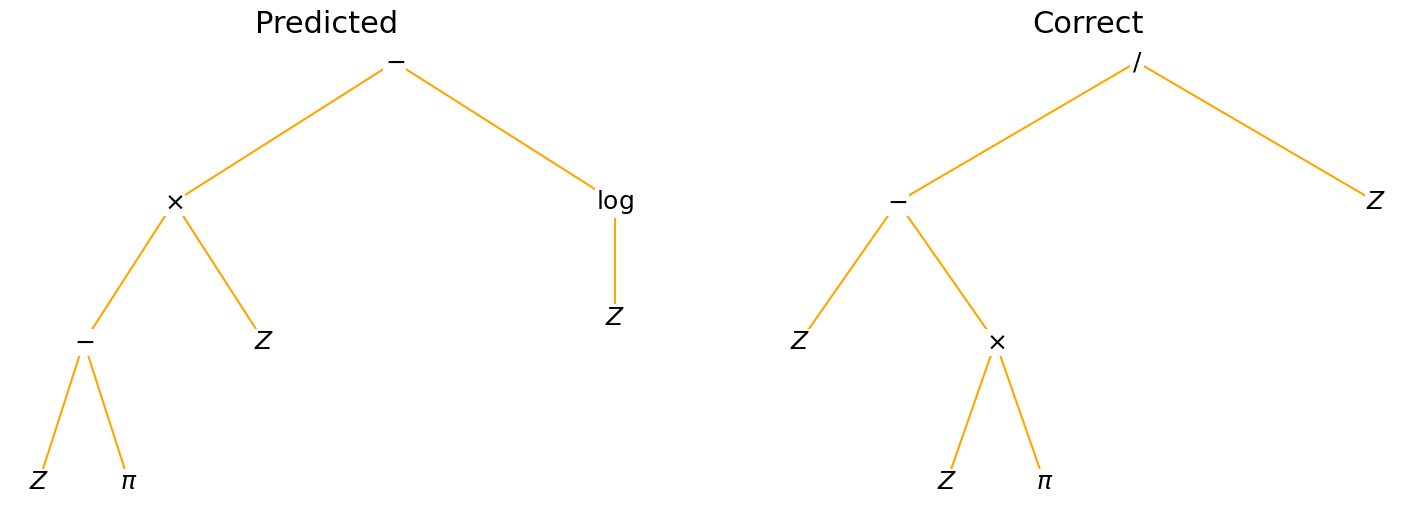

In [41]:
# Shows the graph
def show_graph(root:Node, root_x=0, root_y=0, level=1, color="orange"):
    plt.axis("off")
    dist_mid = np.sqrt(2)
    theta = 45/180 * np.pi / (0.6*level + 0.4) # I wanted do 1/level, but it was horrendous for big graphs
    font_space = 0.3
        
    # Plot node
    plt.text(root_x, root_y, f"${token2symbol[root.val]}$",
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='center', va='center', 
             fontsize=18)
    
    # Plot children
    if root.left and root.right:
        x_left, y_left = root_x - dist_mid * np.tan(theta) + font_space, root_y - dist_mid - font_space
        x_right, y_right = root_x + dist_mid * np.tan(theta) - font_space, y_left
        
        # Show line and then recursively show left side
        plt.plot((root_x, x_left), (root_y, y_left), color=color)
        show_graph(root.left, x_left, y_left, level+1, color)
        
        # Show line and then recursively show right side
        plt.plot((root_x, x_right), (root_y, y_right), color=color)
        show_graph(root.right, x_right, y_right, level+1, color)
    elif root.right:
        x_mid, y_mid = root_x, root_y - dist_mid
        plt.plot((root_x, x_mid), (root_y, y_mid), color=color)
        # Recursively show graph
        show_graph(root.right, x_mid, y_mid, level+1, color)

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title("Predicted", fontsize=22)
show_graph(predict_graph)
plt.subplot(1,2,2)
plt.title("Correct", fontsize=22)
show_graph(correct_graph)
plt.show()

In [42]:
def graph_equality(root1, root2):
    # In case it's a null-node
    if not root1 or not root2:
        return root1 is None and root2 is None
    # Check for root equality
    if root1.val != root2.val:
        return False
    # Recurse
    return graph_equality(root1.left, root2.left) and graph_equality(root1.right, root2.right)
graph_equality(correct_graph, correct_graph), graph_equality(correct_graph, Node(TT_DIVIDE))

(True, False)

### Examples of node operations

<b>Node Insertion:</b> takes a node and puts a new node in between the current node and it's parent

            1         Insert Node 2 -> 2-4         1
           / \        ------------------->        / \
          2   3                                  4   3
               \                                /     \
                6                              2       6
            
What about the leaf nodes then? Well it will always be better to do a replace if necessary and then let the base case handle the rest

In [43]:
# Assumes that 'parent' isn't a leaf node - note that the 'node' parameter only needs to be specified if parent is None
def node_insert(node, to_insert):
    parent = node.parent
    if not parent:
        to_insert.right = node
        node.parent = to_insert
        return
    
    if parent.right == node:
        parent.right = to_insert
        to_insert.right = node
        
    elif parent.left == node:
        parent.left = to_insert
        to_insert.right = node
        
    to_insert.parent = parent
    node.parent = to_insert

<b>Replace Node:</b> takes a node and the new value it should be given and then replaces the node's value

            1          Replace Node 5 -> 7         1
           / \        ------------------->        / \
          2   3                                  2   3
         / \   \                                / \   \
        4   5   6                              4   7   6


In [44]:
# Replace one node value with another 
def node_replace(node, value_to):
    node.val = value_to

<b>Node Delete:</b> Deletes a node and replaces it with the right or left child with cost equal to the size of the other side

            1                        Delete Node 2,                    1
           / \                       replace with its                 / \
          2   3                      right child (5)                 5   3
         / \                         -------------->                / \
        4   5                                                      6   7
           / \
          6   7

Note that it does not make sense to make a ternary tree, as this would entail completely deleting one of the three branches which reduces to just introducing the cost described above

In [45]:
# Delete node and replace with right or left subnode (if applicable) - note that it is assummed not to be the root (with good reason)
def node_delete(node, replace_w_right=True):
    if replace_w_right:
        if node.parent.right == node:
            node.parent.right = node.right
        else:
            node.parent.left = node.right
    else:
        if node.parent.right == node:
            node.parent.right = node.left
        else:
            node.parent.left = node.left
            
    # This is just a nicety for later
    node.parent = None

In [46]:
# Delete whole subtree
def node_delete_all(node):
    # If is root
    if not node.parent: 
        node = None
        
    elif node.parent.right == node:
        node.parent.right = None
        
    elif node.parent.left == node:
        node.parent.left = None
    
    # This is just a nicety for later
    node.parent = None

<b>Node Swap:</b> Swaps the left child with the right child of a node

         1                           Node Swap: swap                        1
       /   \                         subtrees 2 and 3                     /   \
      2     3                        -------------->                     3     2
     / \   / \                                                          / \   / \
    4   5 6   7                                                        6   7 4   5

In [47]:
# Swaps one child with another
def node_swap(node):
    node.left, node.right = node.right, node.left

# Tree Edit Distance Algorithm
`root_pred` is the root of the predicted tree

`root_correct` is the root of the correct tree

Does a simultaneous BFS and each time a discrepancy is encountered, every tool in the arsenal above is thrown at it (not actually, only the result - like for lehvenstein), and the action used is recorded so the result also provides what operations are needed where


An important note is that because of the `Replace and Swap` operator TED(a,b) is not necessarily TED(b,a), based on the commutativity of the replacement operator

In [48]:
class TreeEditDistance:
    def __init__(self):
        self.cache = {}
        
    def calculate(self, root_predict, root_correct):
        key = (",".join(graph_to_postfix(root_predict)), ",".join(graph_to_postfix(root_correct)))
        if key in self.cache:
            return self.cache[key]
        
        # Base case
        if not root_predict or not root_correct:
            return (max(node_count(root_predict), node_count(root_correct)), "Da") # Delete all none-null nodes
        
        # Replace cost is 1 if the root nodes contain different values
        replace_cost = int(root_predict.val != root_correct.val)
        
        # Recurse and calculate the minimum distance
        min_dist, operation = min( 
                       (self.calculate(root_predict.left, root_correct.left)[0] + self.calculate(root_predict.right, root_correct.right)[0] + replace_cost, "R"), # Replace Node
                       (self.calculate(root_predict.left, root_correct.right)[0] + self.calculate(root_predict.right, root_correct.left)[0] + replace_cost + (1 if not root_correct.val in commutative_operators else 0), "RS"), # Replace Node + Swap Node
                       (self.calculate(None, root_correct.left)[0] + self.calculate(root_predict, root_correct.right)[0] + 1, "I"), # Insert Node
                       (self.calculate(root_predict.left, root_correct)[0] + node_count(root_predict.right) + 1, "Dl"), # Delete Node and replace with left
                       (self.calculate(root_predict.right, root_correct)[0] + node_count(root_predict.left) + 1, "Dr"), # Delete Node and replace with right
                       key = lambda v: v[0]
                      )

        self.cache[key] = (min_dist, operation)
        return (min_dist, operation)
    
    def __call__(self, root_predict, root_correct):
        return self.calculate(root_predict, root_correct)[0]

### Simple tests

In [49]:
# Main test - expected: 5
TED = TreeEditDistance()
TED.calculate(predict_graph, correct_graph)

(5, 'R')

In [50]:
# Test replace
TED(Node(TT_PLUS, Node(TT_INTEGER), Node(TT_PI)), Node(TT_PLUS, Node(TT_INTEGER), Node(TT_INTEGER)))

1

In [51]:
# Test delete
TED(Node(TT_MINUS, Node(TT_INTEGER), Node(TT_INTEGER)), Node(TT_MINUS, None, Node(TT_INTEGER)))

1

In [52]:
# Test insert
TED(Node(TT_MINUS, None, Node(TT_INTEGER)), Node(TT_MINUS, Node(TT_INTEGER), Node(TT_INTEGER)))

1

In [53]:
# Test child node swap - commutative
TED(Node(TT_PLUS, Node(TT_INTEGER), Node(TT_PI)), Node(TT_PLUS, Node(TT_PI), Node(TT_INTEGER)))

0

In [54]:
# Test child node swap - not commutative
TED(Node(TT_MINUS, Node(TT_INTEGER), Node(TT_PI)), Node(TT_MINUS, Node(TT_PI), Node(TT_INTEGER)))

1

In [55]:
# Test equal
TED(Node(TT_PLUS, Node(TT_INTEGER), Node(TT_PI)), Node(TT_PLUS, Node(TT_INTEGER), Node(TT_PI)))

0

In [56]:
# Overlapping subtree test - exptected: 6
TED(
    Node(TT_MULTIPLY, Node(TT_DIVIDE, Node(TT_LOG, None, Node(TT_SQRT, None, Node(TT_INTEGER))), Node(TT_INTEGER)), Node(TT_PI)),
    Node(TT_LOG, None, Node(TT_SQRT, None, Node(TT_PLUS, Node(TT_PI), Node(TT_INTEGER))))
)

6

# Interactive TED
It might seem really inefficient that we're calling TED all over again for every operation, but it is actually not! Remember: we have cached all these states when calculating the TED, thus it's only a matter of traversing the graph and then doing an $O(1)$ lookup in our hashmap (given that we're using the same TreeEditDistance instance each call).


Note: there might be a few bugs, but it works for every case I have thrown at it

In [57]:
## Another test-case - expected: 8
# predicted_graph = Node(TT_MULTIPLY, Node(TT_DIVIDE, Node(TT_LOG, None, Node(TT_SQRT, None, Node(TT_INTEGER))), Node(TT_INTEGER)), Node(TT_PI)),
# correct_graph = Node(TT_LOG, None, Node(TT_SQRT, None, Node(TT_PLUS, Node(TT_PI), Node(TT_INTEGER))))

In [61]:
## Another test-case again - expected: 6
_, predict_graph = graph_from_postfix([Token(t) for t in ["TT_INTEGER", "TT_INTEGER", "TT_DIVIDE"]])
_, correct_graph = graph_from_postfix([Token(t) for t in ["TT_INTEGER", "TT_LOG", "TT_LOG", "TT_LOG", "TT_LOG", "TT_SQRT"]])

In [62]:
## Another test-case againx2 - expected: 4
# predict_graph, correct_graph = correct_graph, predict_graph

Distance: 6


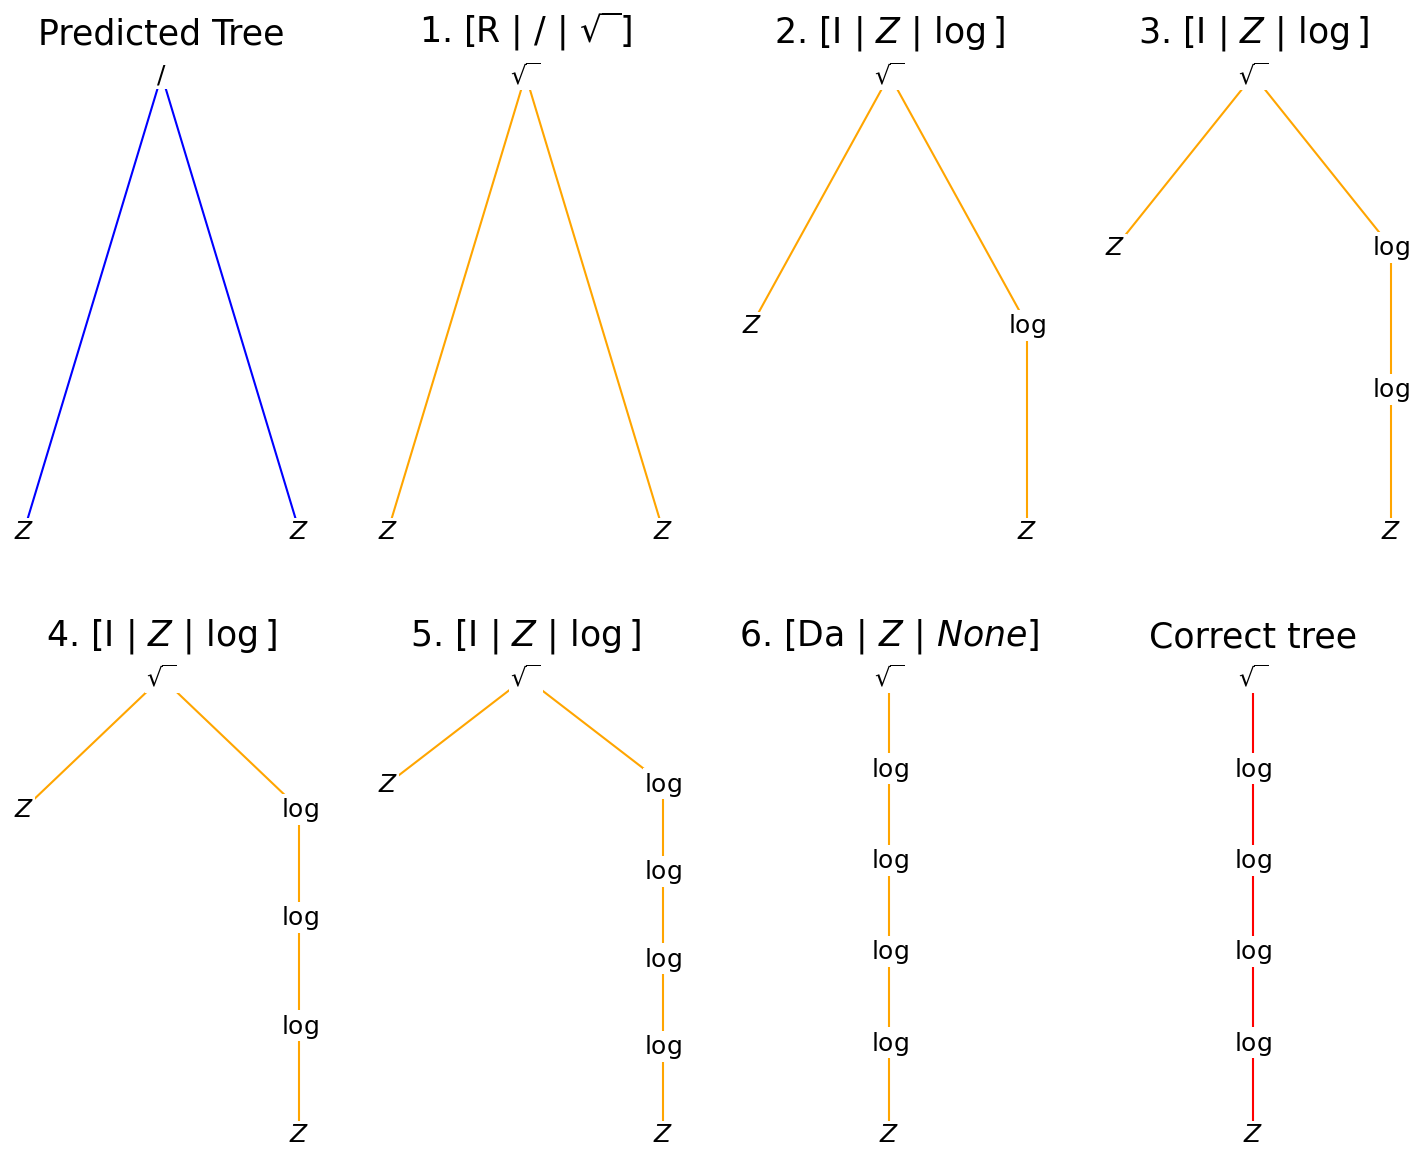

In [63]:
# Instantiate our calculator
TED = TreeEditDistance()

# Some meta-data
total_dist = 0
fontsize = 25
n_rows = 4
n_cols = 4

# Instantiate the subtree-root stack
root_predict, root_correct = copy.copy(predict_graph), copy.copy(correct_graph)
stack = [(root_predict, root_correct)] # Stores the node-pairs for subtrees

plt.figure(figsize=(18, 30))

# Show initial graph
plt.subplot(n_rows,n_cols,1)
plt.title("Predicted Tree", fontsize=fontsize)
show_graph(root_predict, color="blue")

# While there are still operations to perform
idx = 1
while stack:
    node_predict, node_correct = stack.pop()
    if not node_predict and not node_correct: continue
    
    # Lookup operation and distance in cache
    dist, operation = TED.calculate(node_predict, node_correct)
    total_dist += dist
    
    val_pred = node_predict.val if node_predict else None
    val_cor = node_correct.val if node_correct else None
    
    # Modify the graph according to 'operation'
    ## Replace node
    if operation == "R":
        flag = node_predict and node_correct and node_predict.val == node_correct.val
        node_replace(node_predict, node_correct.val)
        # Append to stack
        stack.append((node_predict.left if node_predict else None, node_correct.left if node_correct else None))
        stack.append((node_predict.right if node_predict else None, node_correct.right if node_correct else None))
        if flag: 
            continue
        
    ## Replace node and swap
    elif operation == "RS":
        node_swap(node_predict)
        node_replace(node_predict, node_correct.val)
        # Append swapped to stack
        stack.append((node_predict.left if node_predict else None, node_correct.left if node_correct else None))
        stack.append((node_predict.right if node_predict else None, node_correct.right if node_correct else None))
    
    ## Insert node
    elif operation == "I":
        node_insert(node_predict, Node(node_correct.val))
        # Append to stack
        stack.append((None, node_correct.left if node_correct else None))
        stack.append((node_predict, node_correct.right if node_correct else None))

    ## Delete and replace with left
    elif operation == "Dl":
        node_delete(node_predict, False)
        # Append to stack
        stack.append((node_predict.left if node_predict else None, node_correct))
    
    ## Delete and replace with right
    elif operation == "Dr":
        node_delete(node_predict)
        # Append to stack
        stack.append((node_predict.right if node_predict else None, node_correct))
    
    ## Delete all
    elif operation == "Da":
        # In case a previous "Da" has already deleted this subtree, skip
        root_before = node_predict
        while root_before and root_before.parent: root_before = root_before.parent
        if root_before != root_predict: 
            continue
            
        # Delete all
        node_delete_all(node_predict)
    
    # Show the modified graph
    idx += 1
    plt.subplot(n_rows,n_cols,idx)
    plt.title(fr"{idx-1}. [{operation} | ${token2symbol[val_pred]}$ | ${token2symbol[val_cor]}$]", fontsize=fontsize)
    show_graph(root_predict)
    
print(f"Distance: {TED(predict_graph, correct_graph)}")
plt.subplot(n_rows,n_cols,idx+1)
plt.title("Correct tree", fontsize=fontsize)
show_graph(root_correct, color="red")
plt.show()